# Derma Diseases Detection
- Performs fine tuning on Keras VGG16 in order to detect derma diseases such as: nevus, melanoma and seborrheic_keratosis

In [31]:
# Import Keras with tensorflow backend
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.applications import VGG16

# Import OpenCV
import cv2

# Utility
import os
import numpy as np
import itertools
import random
from collections import Counter
from glob import iglob

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

# Confusion Matrix & classification report
from sklearn.metrics import confusion_matrix, classification_report

# Plot
import matplotlib.pyplot as plt
%matplotlib inline 

### Settings
Define all settings usefull for next steps

In [32]:
# Set dataset folder path
BASE_DATASET_FOLDER = "dataset/" #os.path.join("..","input","derma_disease_dataset","dataset")
TRAIN_FOLDER = "train"
VALIDATION_FOLDER = "validation"
TEST_FOLDER = "test"

# ResNet50 image size
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

# Keras settings
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 0.0001
MODEL_PATH = os.path.join("derma_diseases_detection.h5")

### Data agumentation
Read images in batches directly from folders and perform data augmentation

In [33]:
def percentage_value(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

def plot_dataset_description(path, title):
    classes = []
    for filename in iglob(os.path.join(path, "**","*.jpg")):
        classes.append(os.path.split(os.path.split(filename)[0])[-1])

    classes_cnt = Counter(classes)
    values = list(classes_cnt.values())
    labels = list(classes_cnt.keys())

    plt.figure(figsize=(8,8))
    plt.pie(values, labels=labels, autopct=lambda pct: percentage_value(pct, values), 
            shadow=True, startangle=140)

    plt.title(title)    
    plt.show()

In [34]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        os.path.join(BASE_DATASET_FOLDER, TRAIN_FOLDER),
        target_size=IMAGE_SIZE,
        batch_size=TRAIN_BATCH_SIZE,
        class_mode='categorical', 
        shuffle=True)

Found 938 images belonging to 3 classes.


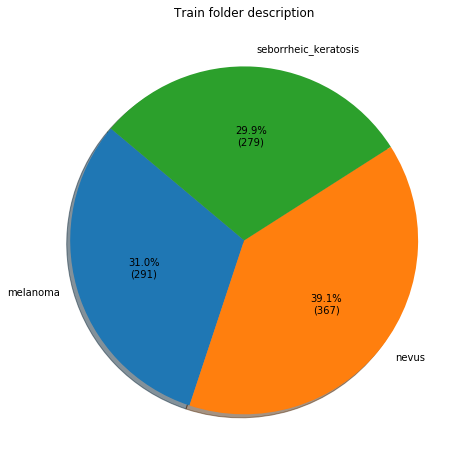

In [35]:
plot_dataset_description(os.path.join(BASE_DATASET_FOLDER, TRAIN_FOLDER), "Train folder description")

In [36]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        os.path.join(BASE_DATASET_FOLDER, VALIDATION_FOLDER),
        target_size=IMAGE_SIZE,
        class_mode='categorical', 
        shuffle=False)

Found 97 images belonging to 3 classes.


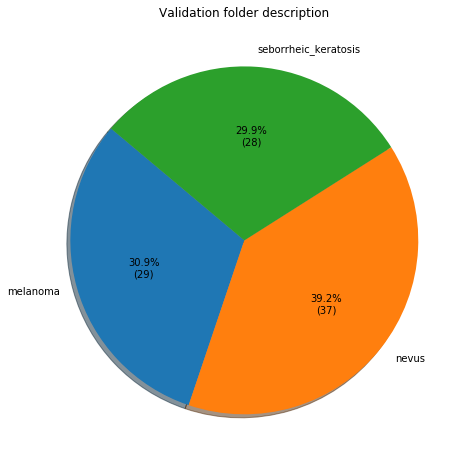

In [37]:
plot_dataset_description(os.path.join(BASE_DATASET_FOLDER, VALIDATION_FOLDER), "Validation folder description")

In [38]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        os.path.join(BASE_DATASET_FOLDER, TEST_FOLDER),
        target_size=IMAGE_SIZE,
        batch_size=VAL_BATCH_SIZE,
        class_mode='categorical', 
        shuffle=False)

Found 368 images belonging to 3 classes.


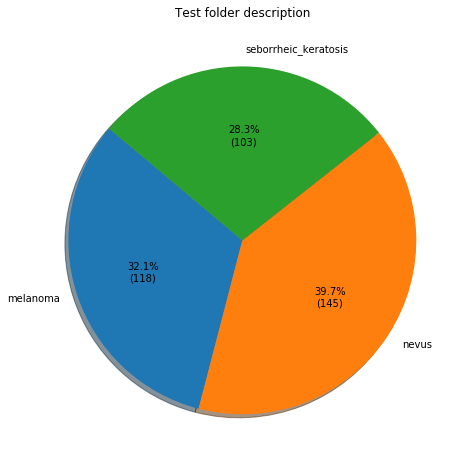

In [39]:
plot_dataset_description(os.path.join(BASE_DATASET_FOLDER, TEST_FOLDER), "Test folder description")

In [40]:
classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

{0: 'melanoma', 1: 'nevus', 2: 'seborrheic_keratosis'}


### Load VGG16 model
Load the pre-trained VGG16 model without the top layer

In [41]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

### Freeze the layers except the last 4 layers

In [42]:
for layer in vgg_model.layers[:-4]:
    layer.trainable = False

### Create model

In [43]:
# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_model)
 
# Add new layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2)) #to avoid overfiting 
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

In [44]:
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                

### Compile model
Compile model specifying the optimizer learning rate

In [45]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['acc'])

### Train model
train model using validation dataset for validate each steps

In [46]:
%%time
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=val_generator,
        validation_steps=val_generator.samples//val_generator.batch_size)

Epoch 1/50
14/14 [==============================] - 515s 37s/step - loss: 1.1433 - acc: 0.3822 - val_loss: 1.2583 - val_acc: 0.5521
Epoch 2/50
14/14 [==============================] - 487s 35s/step - loss: 0.9880 - acc: 0.5229 - val_loss: 0.6255 - val_acc: 0.8154
Epoch 3/50
14/14 [==============================] - 487s 35s/step - loss: 0.8730 - acc: 0.6190 - val_loss: 0.7227 - val_acc: 0.6462
Epoch 4/50
14/14 [==============================] - 499s 36s/step - loss: 0.8114 - acc: 0.6629 - val_loss: 0.4338 - val_acc: 0.7538
Epoch 5/50
14/14 [==============================] - 491s 35s/step - loss: 0.7790 - acc: 0.6784 - val_loss: 0.7630 - val_acc: 0.6979
Epoch 6/50
14/14 [==============================] - 491s 35s/step - loss: 0.7781 - acc: 0.6751 - val_loss: 0.4970 - val_acc: 0.6000
Epoch 7/50
14/14 [==============================] - 526s 38s/step - loss: 0.7338 - acc: 0.6876 - val_loss: 0.8757 - val_acc: 0.5846
Epoch 8/50
14/14 [==============================] - 506s 36s/step - loss: 0.

In [48]:
model.save(MODEL_PATH)

### Check Performance
Plot training and validation accuracy and loss

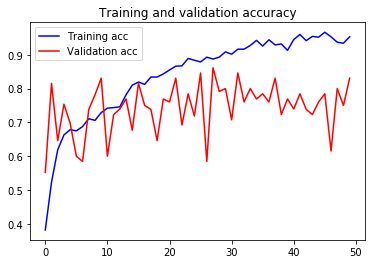

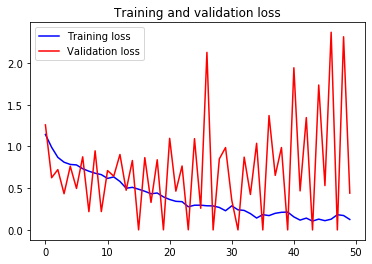

In [49]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Test model
Evauate model using test dataset

In [50]:
%%time
loss, accuracy = model.evaluate_generator(test_generator,steps=test_generator.samples//test_generator.batch_size)

Wall time: 3min 1s


In [51]:
print("Accuracy: %f\nLoss: %f" % (accuracy,loss))

Accuracy: 0.714674
Loss: 11.285002


### Confusion Matrix
Build and plot confusion matrix

In [52]:
%%time
Y_pred = model.predict_generator(test_generator,verbose=1, steps=test_generator.samples//test_generator.batch_size)

46/46 [==============================] - 189s 4s/step
Wall time: 3min 9s


In [53]:
y_pred = np.argmax(Y_pred, axis=1)

In [55]:
cnf_matrix = confusion_matrix(test_generator.classes, y_pred)

In [58]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12,12))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=8)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

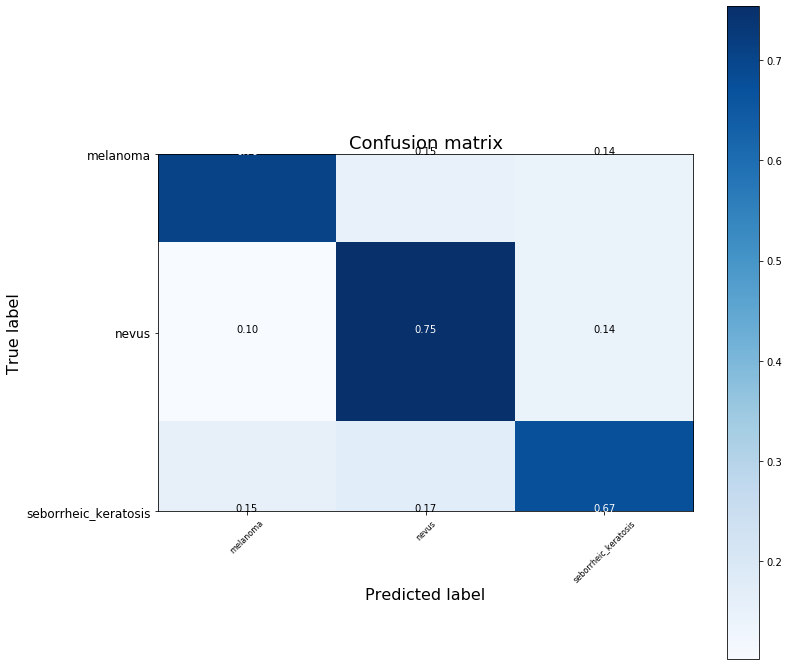

In [59]:
plot_confusion_matrix(cnf_matrix, list(classes.values()))

### Classification Report
Print classification report

In [60]:
print(classification_report(test_generator.classes, y_pred, target_names=list(classes.values())))

                      precision    recall  f1-score   support

            melanoma       0.73      0.70      0.72       118
               nevus       0.75      0.75      0.75       146
seborrheic_keratosis       0.65      0.67      0.66       104

            accuracy                           0.71       368
           macro avg       0.71      0.71      0.71       368
        weighted avg       0.72      0.71      0.71       368



### Random test
Random sample images from test dataset and predict 

In [61]:
def load_image(filename):
    img = cv2.imread(os.path.join(BASE_DATASET_FOLDER, TEST_FOLDER, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: nevus, file: nevus\ISIC_0014185.jpg
PREDICTED: class: seborrheic_keratosis, confidence: 0.455311


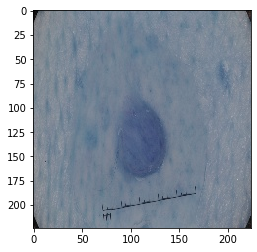

<Figure size 432x288 with 0 Axes>

SOURCE: class: nevus, file: nevus\ISIC_0013112.jpg
PREDICTED: class: nevus, confidence: 0.841995


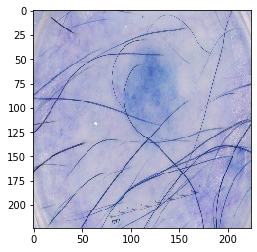

SOURCE: class: nevus, file: nevus\ISIC_0013592.jpg
PREDICTED: class: nevus, confidence: 0.999876


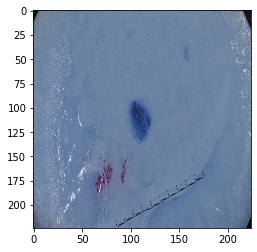

<Figure size 432x288 with 0 Axes>

SOURCE: class: seborrheic_keratosis, file: seborrheic_keratosis\ISIC_0013056.jpg
PREDICTED: class: nevus, confidence: 0.534236


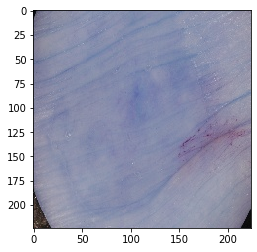

<Figure size 432x288 with 0 Axes>

SOURCE: class: melanoma, file: melanoma\ISIC_0011736.jpg
PREDICTED: class: melanoma, confidence: 0.999842


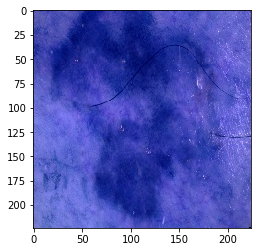

<Figure size 432x288 with 0 Axes>

SOURCE: class: seborrheic_keratosis, file: seborrheic_keratosis\ISIC_0012974.jpg
PREDICTED: class: seborrheic_keratosis, confidence: 0.973942


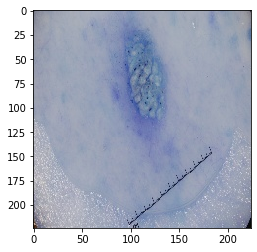

<Figure size 432x288 with 0 Axes>

SOURCE: class: seborrheic_keratosis, file: seborrheic_keratosis\ISIC_0012704.jpg
PREDICTED: class: seborrheic_keratosis, confidence: 0.778247


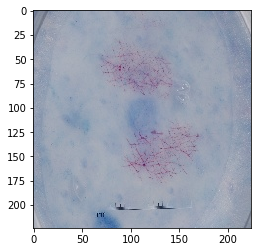

<Figure size 432x288 with 0 Axes>

SOURCE: class: melanoma, file: melanoma\ISIC_0011743.jpg
PREDICTED: class: melanoma, confidence: 1.000000


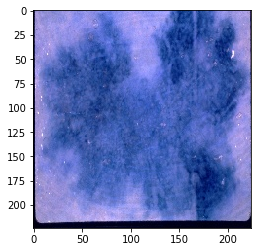

<Figure size 432x288 with 0 Axes>

SOURCE: class: seborrheic_keratosis, file: seborrheic_keratosis\ISIC_0012772.jpg
PREDICTED: class: seborrheic_keratosis, confidence: 0.941896


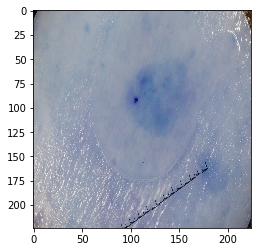

<Figure size 432x288 with 0 Axes>

SOURCE: class: nevus, file: nevus\ISIC_0013140.jpg
PREDICTED: class: nevus, confidence: 0.998552


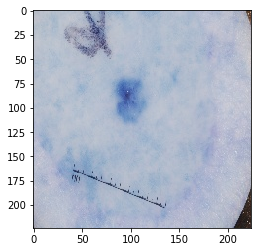

<Figure size 432x288 with 0 Axes>

In [62]:
for idx, filename in enumerate(random.sample(test_generator.filenames, 10)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()